### group members
* Max Dunger
* [Yannik Motzet](mailto:yannik.motzet@outlook.com)

# Übung 2: Hauptkomponentenanalyse
## 2. Eigengesichter

In [53]:
import os
from skimage import io
from skimage.transform import resize
import numpy as np
import pandas as pd
import scipy

from matplotlib import pyplot as plt

# print(skimage.__version__)

a.)

In [6]:
directory = r'.\lfw_funneled'

selected_persons = []
number_of_pictures = []

# iterate trough subdirectories
for subdir, __, __  in os.walk(directory):
    # print(subdir)
    number = 0
    # count files in subdirectory
    for file in os.listdir(subdir):
        if file.endswith(".jpg"): number+=1
    if number >= 70:
        print(subdir + 5*" " + str(number))
        selected_persons.append(subdir)
        number_of_pictures.append(number)

        
print(number_of_pictures)
print(sum(number_of_pictures))
print(len(selected_persons))

.\lfw_funneled\Ariel_Sharon     77
.\lfw_funneled\Colin_Powell     236
.\lfw_funneled\Donald_Rumsfeld     121
.\lfw_funneled\George_W_Bush     530
.\lfw_funneled\Gerhard_Schroeder     109
.\lfw_funneled\Hugo_Chavez     71
.\lfw_funneled\Tony_Blair     144
[77, 236, 121, 530, 109, 71, 144]
1288
7


b.)

In [7]:
# training data
training_data_number = sum(number_of_pictures) - len(selected_persons)

# training_images = np.full((32, 32, training_data_number), None)
# training_images = np.full((training_data_number, 32*32), None)
training_images = np.empty((training_data_number, 32*32))
training_labels = np.full((training_data_number), None)

# validation data
# validation_images = np.full((32, 32, len(selected_persons)), None)
# validation_images = np.full((len(selected_persons), 32*32), None)
validation_images = np.empty((len(selected_persons), 32*32))
validation_labels = np.full((len(selected_persons)), None)


k = 0
# for person in selected_persons:
for i in range(len(selected_persons)):
    person_name = selected_persons[i].split("\\")[-1]

    pictures = os.listdir(selected_persons[i])

    # training data
    for j in range(len(pictures)-1):
        filepath = selected_persons[i] + '\\' + pictures[j]
        
        # load greyscale image
        image = io.imread(filepath, as_gray = True)
        
        # crop
        pixel_crop = 90
        # x1:x2,y1:y2
        image = image[pixel_crop+13:250-pixel_crop+13, pixel_crop:250-pixel_crop]
        
        # scale image
        image = resize(image, (32, 32))
        
        # add to training matrix
        # training_images[k, :, :] = image
        # training_images[k, :] = np.reshape(image, (1024))
        training_images[k, :] = image.flatten().astype('float')
        # print(np.reshape(image, (1, 1024)).shape)
        training_labels[k] = person_name
        k+=1

        # # plot image
        # io.imshow(image)
        # plt.show()

    # validation data
    filepath = selected_persons[i] + '\\' + pictures[-1]
    # load greyscale image
    image = io.imread(filepath, as_gray = True)
    # crop
    pixel_crop = 90
    image = image[pixel_crop+13:250-pixel_crop+13, pixel_crop:250-pixel_crop]
    # scale image
    image = resize(image, (32, 32))
    # add to validation matrix
    # validation_images[:, :, i] = image
    validation_images[i, :] = np.reshape(image, (1, 1024))
    validation_labels[i] = person_name

print(training_images.shape)     

(1281, 1024)


c.) Hauptkomponentenanalyse

In [8]:
images_dataframe = pd.DataFrame(data=training_images)

In [9]:
def intrinsic_value(X):
  dim_n = X.shape[0]
  mean= np.mean(X, axis=0)
  std= np.std(X, axis=0)
  X_std = (X-mean)/std
  u, d, vt = np.linalg.svd(X_std)
  eigenwerte = d**2/(dim_n-1)
  return eigenwerte, vt

In [10]:
eigenwerte, vt = intrinsic_value(images_dataframe)

eigenwerte_150 = pd.DataFrame(columns=["Eigenwert"])
eigenwerte_150.iloc[:, 0] = eigenwerte[0:150]
eigenwerte_150

,Eigenwert
0,330.336261
1,143.027123
2,50.473425
3,38.727770
4,30.382715
...,...
145,0.350099
146,0.348271
147,0.342869
148,0.334273


In [15]:
print(vt.shape)

(1024, 1024)


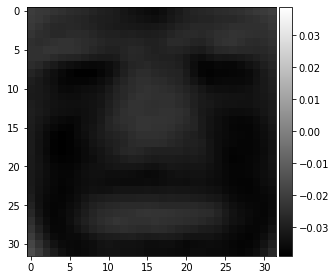

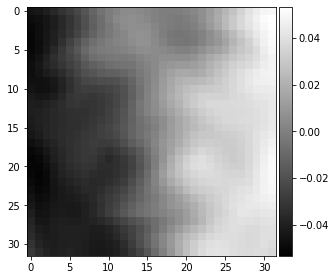

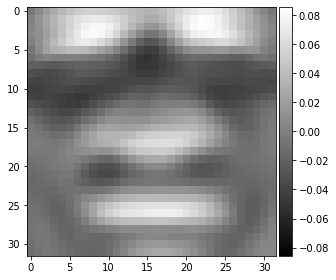

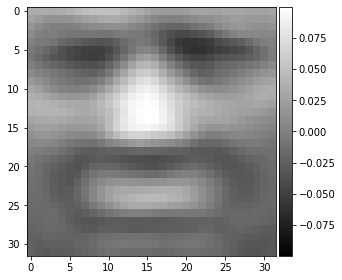

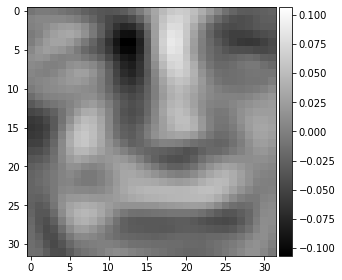

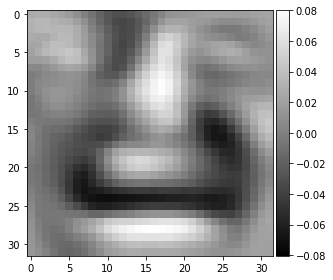

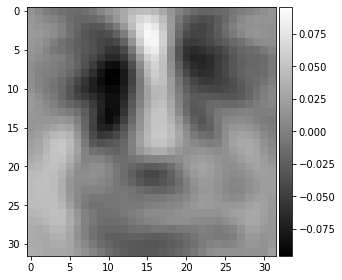

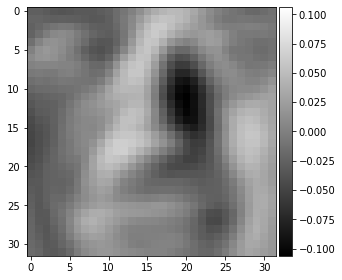

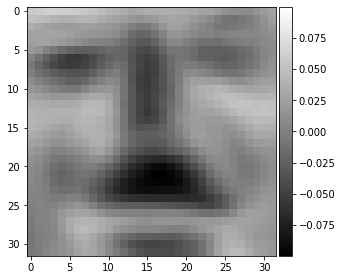

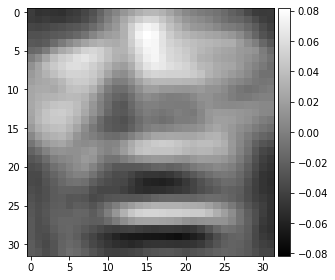

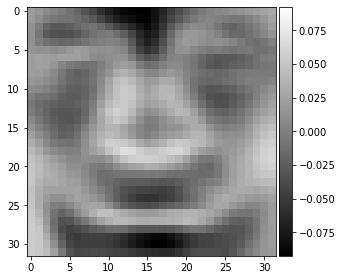

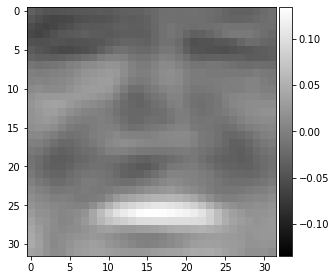

In [17]:
eigengesichter_12 = []

for i in range(12):
    eigengesichter_12.append(np.reshape(vt[i, :], (32, 32)))

for gesicht in eigengesichter_12:
    # plot image
    io.imshow(gesicht, cmap='gray')
    plt.show()


Interpretation von Ergebnis: Grundcharakteristik eines menschlichen Gesichtes

d)

In [33]:
eigengesichter_7 = vt[0:7, :]

(7, 1024)

In [47]:
# validation data
number_of_hauptkomponenten = 7
validation_merkmale = np.empty((validation_images.shape[0], number_of_hauptkomponenten))

for i in range(validation_images.shape[0]):
    validation_merkmale[i] = np.reshape(np.dot(eigengesichter_7, validation_images[i ,:]), (1, 7))

validation_merkmale.shape

(7, 7)

In [52]:
# training data
training_merkmale = np.empty((training_images.shape[0], number_of_hauptkomponenten))

for i in range(training_images.shape[0]):
    training_merkmale[i] = np.reshape(np.dot(eigengesichter_7, training_images[i ,:]), (1, 7))
training_merkmale.shape

(1281, 7)

In [58]:
# prediction
for validation_merkmal in validation_merkmale:
    k = 0
    smallest_index = 0
    minimum_distance = scipy.spatial.distance.euclidean(validation_merkmal, training_merkmale[0, :])
    for training_merkmal in training_merkmale:
        k+=1
        distance= scipy.spatial.distance.euclidean(validation_merkmal, training_merkmal)
        if distance < minimum_distance:
            minimum_distance = distance
            smallest_index = k
    print(training_labels[smallest_index])

print('\n')

for name in validation_labels:
    print(name)

George_W_Bush
Hugo_Chavez
George_W_Bush
George_W_Bush
Gerhard_Schroeder
Colin_Powell
Colin_Powell


Ariel_Sharon
Colin_Powell
Donald_Rumsfeld
George_W_Bush
Gerhard_Schroeder
Hugo_Chavez
Tony_Blair


George W Bush und Gerhard Schroeder wurden korrekt klassifiziert